# LUXE-NPOD Background Studies

Studies on kinematics distributions using LUXE signal samples.

We use two phase-0 samples:
- e0ppw_3.0_g4{0-4}
- e0ppw_7.0_g4{0-4}

Our reference page for LUXE signal MC samples is https://confluence.desy.de/display/LS/Signal+MC.

The notebook is base on uproot and pandas, and I am following the basic uproot documentation here: https://uproot.readthedocs.io/en/latest/basic.html

In [1]:
import numpy as np
import pandas as pd

In [3]:
import uproot

If we are at KIT, our signal samples are stored at KIT in Torben's /ceph directory:
`/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw`

If we are at DESY, our signal samples are stored at:
`/nfs/dust/luxe/group/MCProduction/Signal/g4/ptarmigan-v0.11/elaser/phase1/npod/`

In [7]:
!ls /ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw


ls: cannot access /ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw: No such file or directory


In [4]:
# For now, open just one file
#phase0_folder = "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/"

#file_3_0 = uproot.open(phase0_folder + "e0ppw_3_0_0_particles_g4.root")

#file_3_0

In [5]:
#file_3_0["Tracks"]

We are interested in the `Tracks` TTree

In [6]:
# Get access to the 'Tracks' TTree 
#Tracks = uproot.open(phase0_folder + "e0ppw_3_0_0_particles_g4.root:Tracks")

In [7]:
# Show branches in "Tracks"
#Tracks.keys()

In [8]:
# Defining data frame from Tracks tree with the interesting variables
#df = Tracks.arrays(["E", "pdg","detid","weight","theta","phi","vtxx","vtxy","vtxz","px","py","pz","x","y","z"], library="pd")

We have more than one set of files, depending on the phase we want to study and the laser properties. 

We define a set of dictionaries, one for each possbility. This will make the code more 'automatic' in understanding what files it has to read, where to store the output, etc.

In [45]:
from collections import OrderedDict

# Define variables 
variablesDic = {}

# Phase0, xi = 3.0 
variablesDic['phase0_e0ppw_3_0'] = {
    'output_folder' : 'e0ppw_3_0',
    'opening_list'  : [
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_0_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_1_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_2_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_3_particles_g4.root:Tracks",
    ],
    'BX'            : 4,
    'detid'         : 9000,
}

# Phase0, xi = 7.0
variablesDic['phase0_e0ppw_7_0'] = {
    'output_folder' : 'e0ppw_7_0',
    'opening_list'  : [
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_0_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_1_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_2_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_3_particles_g4.root:Tracks",
    ],
    'BX'            : 4,
    'detid'         : 9000,
}

from npod_files import npod_files_list
# Phase1, NPOD sample
variablesDic['npod'] = {
    'output_folder' : 'npod',
    'opening_list'  : npod_files_list,
    'BX'            : 5,
    'detid'         : 9000,
}

In [131]:
# Define the phase and laser properties to study. Call it 'era'
era = 'npod'

# These are our global variables
opening_list  = variablesDic[era]['opening_list']
output_folder = variablesDic[era]['output_folder'] 
BX            = variablesDic[era]['BX']
detid         = variablesDic[era]['detid']

# The energy cut does not depend on the phase, but on the detector: it is always the same.
# Since we cannot detect particles with energy below 'energy_cut' in any case, should we
# already cut them when we load the files?
# energy_cut = 0.5 # GeV
energy_cut = 0.0 # GeV

Read all the files at the same time. To reduce the memory needed, we load them one by one, selecting only events with the correct detid. We then concatenate the data frames associated to each file.

In [47]:
# df=pd.DataFrame()
Tracks = uproot.open(opening_list[0])
df_tmp = Tracks.arrays(["E", "pdg","detid","weight","theta","phi","vtxx","vtxy","vtxz","px","py","pz","x","y","z"], library="pd")
df_bsm = df_tmp[(df_tmp["detid"]==detid) & (df_tmp["E"]>energy_cut)]
df_bsm.head(10)

for i in range(1, len(opening_list)):
    Tracks = uproot.open(opening_list[i])
    df_tmp = Tracks.arrays(["E", "pdg","detid","weight","theta","phi","vtxx","vtxy","vtxz","px","py","pz","x","y","z"], library="pd")
    df_tmp_bsm = df_tmp[(df_tmp["detid"]==detid) & (df_tmp["E"]>energy_cut)]
    df_bsm.append(df_tmp_bsm)

## Background studies

We want to check which events produces signatures that can mimic our signal:
- two neutrons
- two photons
- one neutron and one photon

To do so, we look at what hits our BSM calorimeter (for the moment, just a dummy volume).

We identify tracks reaching the BSM calorimeter by requiring `detid` = 9000

In [49]:
df_bsm.head(10)

E   pdg  detid  weight     theta       phi  \
entry subentry                                                          
28    11        1.580376e-08  2112   9000    15.0  1.417344  3.112908   
29    11        1.360063e-05  2112   9000    15.0  0.836086 -0.181231   
84    9         1.381918e-06  2112   9000    15.0  1.105614 -1.141345   
      10        3.613199e-08  2112   9000    15.0  0.422653  1.692819   
97    9         1.446881e-11  2112   9000    15.0  2.034465  0.115710   
      18        1.666059e-03    12   9000    15.0  0.098163  1.561672   
112   14        2.670579e-07  2112   9000    15.0  1.472400 -2.653717   
123   11        4.180704e-04    12   9000    15.0  0.213840 -2.635998   
145   16        4.189718e-06  2112   9000    15.0  1.073171 -2.277851   
      18        1.312131e-03    22   9000    15.0  1.449273  1.106148   

                       vtxx         vtxy          vtxz        px  \
entry subentry                                                     
28    11        -144.222109     0.978329   7300.181509 -0.000170   
29    11        -173.224276     1.535980   7383.765514  0.003690   
84    9         -118.567765    -0.271682   7331.468110  0.000600   
      10        -118.567765    -0.271682   7331.468110 -0.000013   
97    9         -210.627404    -2.656903   7353.539416  0.000005   
      18         197.941282  -106.676469   9423.120470  0.000001   
112   14        -216.505788   -14.281985   7322.414471 -0.000623   
123   11        1823.812677   -71.093102   8104.752332 -0.000078   
145   16         -71.405391   -65.903453   7130.353868 -0.001602   
      18        -677.570176 -1128.862202  15832.425023  0.000584   

                          py        pz           x            y             z  
entry subentry                                                                 
28    11        4.884470e-06  0.000026 -901.537057   974.468968  16000.000000  
29    11       -6.761320e-04  0.003389  563.991837  -612.631079  16000.000000  
84    9        -1.309446e-03  0.000723 -838.101571   289.321843  16000.000000  
      10        1.060862e-04  0.000238 -317.105048   145.500696  16000.000000  
97    9         5.384387e-07 -0.000002  314.499203  -677.703046  16178.060000  
      18        1.632754e-04  0.001658  203.850783   540.981912  16000.000000  
112   14       -3.304587e-04  0.000070 -532.969069  -273.192701  16000.000000  
123   11       -4.296972e-05  0.000409  323.792702  -901.488795  16000.000000  
145   16       -1.874535e-03  0.001339  265.295243  1002.500000  16120.867985  
      18        1.164367e-03  0.000159  -62.692465    97.823992  16000.000000

### Two neutron case
We start by looking at events with two neutrons. We select neutrons using the `pdg` variable, that for neutrons is `2112`.

In [50]:
# Select events with exactly two neutrons
def get_sum(df_bsm):
    """Returns sum of 'pdg' values in each event"""
    return sum(df_bsm['pdg'])

def is_neutron(df_bsm):
    """Returns number of neutrons in each event"""
    return sum(df_bsm['pdg'] == 2112)


# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has EXACTLY two neutrons
list_nn = df_bsm.groupby('entry').apply(get_sum)==4224

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST two neutrons
list_multi_n = df_bsm.groupby('entry').apply(is_neutron) > 1

In [51]:
# We convert the series into a 'mask' that we use to filter the dataframe
# mask_nn = list_nn[list_nn==True].index # Exactly and only two neutrons in the event
mask_nn = list_multi_n[list_multi_n==True].index # At least two neutrons in the event

In [52]:
# Here we filter
df_bsm_nn = df_bsm.loc[mask_nn]
df_bsm_nn.head(10)

E   pdg  detid  weight     theta       phi  \
entry subentry                                                          
84    9         1.381918e-06  2112   9000    15.0  1.105614 -1.141345   
      10        3.613199e-08  2112   9000    15.0  0.422653  1.692819   
200   77        1.890674e-06  2112   9000    15.0  0.498920  0.459939   
      86        4.597192e-08  2112   9000    15.0  1.778787  3.090234   
498   27        3.821357e-07  2112   9000    15.0  0.702273 -2.282435   
      28        2.733074e-08  2112   9000    15.0  0.629886  1.957775   
919   25        2.543695e-07  2112   9000    15.0  2.178175 -1.376978   
      26        1.310655e-05  2112   9000    15.0  0.407007 -0.715143   
      30        1.382064e-06  2112   9000    15.0  2.778640  0.895073   
1035  23        5.115038e-05  2112   9000    15.0  0.274654 -2.020142   

                      vtxx        vtxy         vtxz        px        py  \
entry subentry                                                            
84    9        -118.567765   -0.271682  7331.468110  0.000600 -0.001309   
      10       -118.567765   -0.271682  7331.468110 -0.000013  0.000106   
200   77       -140.193269  101.808753  7617.844896  0.000808  0.000400   
      86       -414.784457   18.083908  7395.738773 -0.000287  0.000015   
498   27       -387.140033  116.830398  7312.505016 -0.000357 -0.000415   
      28       -387.140033  116.830398  7312.505016 -0.000050  0.000124   
919   25       -170.284618    6.166750  7301.869700  0.000109 -0.000557   
      26        -72.298218  219.619953  7580.345437  0.001483 -0.001288   
      30        -53.930356  275.992581  7787.140463  0.000358  0.000446   
1035  23       -122.789950   -1.160238  7383.478679 -0.001155 -0.002395   

                      pz            x           y             z  
entry subentry                                                   
84    9         0.000723  -838.101571  289.321843  16000.000000  
      10        0.000238  -317.105048  145.500696  16000.000000  
200   77        0.001655  -285.932279  838.645836  16000.000000  
      86       -0.000061  1002.500000 -862.629006  16037.022255  
498   27        0.000647   609.881734  936.008470  16000.000000  
      28        0.000183  -706.645736 -277.000943  16000.000000  
919   25       -0.000395  -639.879616  249.240734  16178.060000  
      26        0.004557   975.420606  147.499989  16000.000000  
      30       -0.001507   969.029526  202.776855  16178.060000  
1035  23        0.009437   125.168517   63.176583  16000.000000

Now that we selected events with at least two neutrons, we want to order, in each event, the particles by their energy, and keep events in which the *two most energetic* particles are neutrons. 

In [53]:
# Sort by particle Energy
df_bsm_nn_sort = df_bsm_nn.groupby('entry').apply(lambda x: x.sort_values(['E'], ascending=False))
df_bsm_nn_sort.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
84    84    9         1.381918e-06  2112   9000    15.0  1.105614 -1.141345   
            10        3.613199e-08  2112   9000    15.0  0.422653  1.692819   
200   200   77        1.890674e-06  2112   9000    15.0  0.498920  0.459939   
            86        4.597192e-08  2112   9000    15.0  1.778787  3.090234   
498   498   27        3.821357e-07  2112   9000    15.0  0.702273 -2.282435   
            28        2.733074e-08  2112   9000    15.0  0.629886  1.957775   
919   919   26        1.310655e-05  2112   9000    15.0  0.407007 -0.715143   
            30        1.382064e-06  2112   9000    15.0  2.778640  0.895073   
            25        2.543695e-07  2112   9000    15.0  2.178175 -1.376978   
1035  1035  23        5.115038e-05  2112   9000    15.0  0.274654 -2.020142   
            25        9.927400e-10  2112   9000    15.0  0.944888 -0.820016   
            27        5.686276e-10  2112   9000    15.0  0.857874 -2.630974   
1457  1457  12        1.562295e-05  2112   9000    15.0  2.385393 -2.376520   
            14        1.700320e-09  2112   9000    15.0  0.637259  0.070532   
1467  1467  16        1.035970e-09  2112   9000    15.0  0.676834 -2.623569   
            17        5.945382e-10  2112   9000    15.0  1.208388 -0.552180   
1653  1653  16        1.724862e-07  2112   9000    15.0  0.646006 -0.659644   
            12        1.750905e-10  2112   9000    15.0  0.595487  1.978473   
            13        1.188806e-10  2112   9000    15.0  1.025557 -1.108045   
2715  2715  25        6.569002e-05  2112   9000    15.0  1.908969 -0.404844   

                            vtxx        vtxy          vtxz        px  \
entry entry subentry                                                   
84    84    9        -118.567765   -0.271682   7331.468110  0.000600   
            10       -118.567765   -0.271682   7331.468110 -0.000013   
200   200   77       -140.193269  101.808753   7617.844896  0.000808   
            86       -414.784457   18.083908   7395.738773 -0.000287   
498   498   27       -387.140033  116.830398   7312.505016 -0.000357   
            28       -387.140033  116.830398   7312.505016 -0.000050   
919   919   26        -72.298218  219.619953   7580.345437  0.001483   
            30        -53.930356  275.992581   7787.140463  0.000358   
            25       -170.284618    6.166750   7301.869700  0.000109   
1035  1035  23       -122.789950   -1.160238   7383.478679 -0.001155   
            25       -122.789950   -1.160238   7383.478679  0.000024   
            27       -122.789950   -1.160238   7383.478679 -0.000022   
1457  1457  12       -442.063324  218.888111   7641.861285 -0.002682   
            14       -132.139956 -147.472640   7231.992567  0.000034   
1467  1467  16        382.637637  -55.290045  10036.982755 -0.000024   
            17        382.637637  -55.290045  10036.982755  0.000027   
1653  1653  16       -199.888861    0.617094   7356.628211  0.000271   
            12         42.858260  345.267882   7119.906031 -0.000004   
            13         42.858260  345.267882   7119.906031  0.000006   
2715  2715  25        -22.010676   33.791730   7370.120014  0.009634   

                            py        pz            x            y  \
entry entry subentry                                                 
84    84    9        -0.001309  0.000723  -838.101571   289.321843   
            10        0.000106  0.000238  -317.105048   145.500696   
200   200   77        0.000400  0.001655  -285.932279   838.645836   
            86        0.000015 -0.000061  1002.500000  -862.629006   
498   498   27       -0.000415  0.000647   609.881734   936.008470   
            28        0.000124  0.000183  -706.645736  -277.000943   
919   919   26       -0.001288  0.004557   975.420606   147.499989   
            30        0.000446 -0.001507   969.029526   202.776855   
         

In [54]:
# Leading particle is a neutron
neutron_mask_0 = df_bsm_nn_sort.groupby('entry').nth(0)['pdg'] == 2112
print(neutron_mask_0[:10])

# Sub-leading particle is a neutron
neutron_mask_1 = df_bsm_nn_sort.groupby('entry').nth(1)['pdg'] == 2112
print(neutron_mask_1[:10])

neutron_mask = neutron_mask_0 & neutron_mask_1

entry
84      True
200     True
498     True
919     True
1035    True
1457    True
1467    True
1653    True
2715    True
2998    True
Name: pdg, dtype: bool
entry
84      True
200     True
498     True
919     True
1035    True
1457    True
1467    True
1653    True
2715    True
2998    True
Name: pdg, dtype: bool


In [55]:
print(neutron_mask[0:10])

# Two leading particles are neutrons
mask_two_n = neutron_mask[neutron_mask==True].index 

entry
84      True
200     True
498     True
919     True
1035    True
1457    True
1467    True
1653    True
2715    True
2998    True
Name: pdg, dtype: bool


In [56]:
# Apply mask to have only events in which two leading particles are neutrons
df_bsm_two_n = df_bsm_nn_sort.loc[mask_two_n]
df_bsm_two_n.head(10)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
84    84    9         1.381918e-06  2112   9000    15.0  1.105614 -1.141345   
            10        3.613199e-08  2112   9000    15.0  0.422653  1.692819   
200   200   77        1.890674e-06  2112   9000    15.0  0.498920  0.459939   
            86        4.597192e-08  2112   9000    15.0  1.778787  3.090234   
498   498   27        3.821357e-07  2112   9000    15.0  0.702273 -2.282435   
            28        2.733074e-08  2112   9000    15.0  0.629886  1.957775   
919   919   26        1.310655e-05  2112   9000    15.0  0.407007 -0.715143   
            30        1.382064e-06  2112   9000    15.0  2.778640  0.895073   
            25        2.543695e-07  2112   9000    15.0  2.178175 -1.376978   
1035  1035  23        5.115038e-05  2112   9000    15.0  0.274654 -2.020142   

                            vtxx        vtxy         vtxz        px        py  \
entry entry subentry                                                            
84    84    9        -118.567765   -0.271682  7331.468110  0.000600 -0.001309   
            10       -118.567765   -0.271682  7331.468110 -0.000013  0.000106   
200   200   77       -140.193269  101.808753  7617.844896  0.000808  0.000400   
            86       -414.784457   18.083908  7395.738773 -0.000287  0.000015   
498   498   27       -387.140033  116.830398  7312.505016 -0.000357 -0.000415   
            28       -387.140033  116.830398  7312.505016 -0.000050  0.000124   
919   919   26        -72.298218  219.619953  7580.345437  0.001483 -0.001288   
            30        -53.930356  275.992581  7787.140463  0.000358  0.000446   
            25       -170.284618    6.166750  7301.869700  0.000109 -0.000557   
1035  1035  23       -122.789950   -1.160238  7383.478679 -0.001155 -0.002395   

                            pz            x           y             z  
entry entry subentry                                                   
84    84    9         0.000723  -838.101571  289.321843  16000.000000  
            10        0.000238  -317.105048  145.500696  16000.000000  
200   200   77        0.001655  -285.932279  838.645836  16000.000000  
            86       -0.000061  1002.500000 -862.629006  16037.022255  
498   498   27        0.000647   609.881734  936.008470  16000.000000  
            28        0.000183  -706.645736 -277.000943  16000.000000  
919   919   26        0.004557   975.420606  147.499989  16000.000000  
            30       -0.001507   969.029526  202.776855  16178.060000  
            25       -0.000395  -639.879616  249.240734  16178.060000  
1035  1035  23        0.009437   125.168517   63.176583  16000.000000

In [57]:
# Two leading particle in the event are neutrons
df_bsm_two_n.iloc[0:2]

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
84    84    9         1.381918e-06  2112   9000    15.0  1.105614 -1.141345   
            10        3.613199e-08  2112   9000    15.0  0.422653  1.692819   

                            vtxx      vtxy        vtxz        px        py  \
entry entry subentry                                                         
84    84    9        -118.567765 -0.271682  7331.46811  0.000600 -0.001309   
            10       -118.567765 -0.271682  7331.46811 -0.000013  0.000106   

                            pz           x           y        z  
entry entry subentry                                             
84    84    9         0.000723 -838.101571  289.321843  16000.0  
            10        0.000238 -317.105048  145.500696  16000.0

Now we build some interesting kinematic variables, per event.

In [58]:
df_nn_kinematics = pd.DataFrame()

In [59]:
# Delta phi 
def delta_phi(df_nn_kinematics):
    d_phi = df_nn_kinematics['phi_1'] - df_nn_kinematics['phi_2']    
    if d_phi >= np.pi: d_phi = d_phi - 2*np.pi
    if d_phi < -np.pi: d_phi = d_phi + 2*np.pi
    return d_phi


# Copying TLorentzVector definition https://root.cern.ch/doc/master/TLorentzVector_8h_source.html#l00498
def inv_mass(E_1, px_1, py_1, pz_1,
             E_2, px_2, py_2, pz_2):
    return np.sqrt( np.absolute((E_1+E_2)**2 - (px_1+px_2)**2 - (py_1+py_2)**2 - (pz_1+pz_2)**2) )
    

In [60]:
# Dirty trick to have the first and second particles: create two separate dataframes
# with the first and second subentry
df_bsm_nn_first  = df_bsm_two_n.groupby('entry').nth(0)
df_bsm_nn_second = df_bsm_two_n.groupby('entry').nth(1)

In [61]:
# Event variables
df_nn_kinematics["weight"] = df_bsm_nn_first["weight"]

# Build first particle
df_nn_kinematics["E_1"] = df_bsm_nn_first["E"]
df_nn_kinematics["m_1"] = 0.939565
df_nn_kinematics["eta_1"] = -np.log(np.tan(0.5*df_bsm_nn_first["theta"]))
df_nn_kinematics["theta_1"] = df_bsm_nn_first["theta"]
df_nn_kinematics["phi_1"] = df_bsm_nn_first["phi"]
df_nn_kinematics["vtxx_1"] = df_bsm_nn_first["vtxx"]
df_nn_kinematics["vtxy_1"] = df_bsm_nn_first["vtxy"]
df_nn_kinematics["vtxz_1"] = df_bsm_nn_first["vtxz"]
df_nn_kinematics["px_1"] = df_bsm_nn_first["px"]
df_nn_kinematics["py_1"] = df_bsm_nn_first["py"]
df_nn_kinematics["pz_1"] = df_bsm_nn_first["pz"]
df_nn_kinematics["x_1"] = df_bsm_nn_first["x"]
df_nn_kinematics["y_1"] = df_bsm_nn_first["y"]
df_nn_kinematics["z_1"] = df_bsm_nn_first["z"]

# Build second particle
df_nn_kinematics["E_2"] = df_bsm_nn_second["E"]
df_nn_kinematics["m_2"] = 0.939565
df_nn_kinematics["eta_2"] = -np.log(np.tan(0.5*df_bsm_nn_second["theta"]))
df_nn_kinematics["theta_2"] = df_bsm_nn_second["theta"]
df_nn_kinematics["phi_2"] = df_bsm_nn_second["phi"]
df_nn_kinematics["vtxx_2"] = df_bsm_nn_second["vtxx"]
df_nn_kinematics["vtxy_2"] = df_bsm_nn_second["vtxy"]
df_nn_kinematics["vtxz_2"] = df_bsm_nn_second["vtxz"]
df_nn_kinematics["px_2"] = df_bsm_nn_second["px"]
df_nn_kinematics["py_2"] = df_bsm_nn_second["py"]
df_nn_kinematics["pz_2"] = df_bsm_nn_second["pz"]
df_nn_kinematics["x_2"] = df_bsm_nn_second["x"]
df_nn_kinematics["y_2"] = df_bsm_nn_second["y"]
df_nn_kinematics["z_2"] = df_bsm_nn_second["z"]


In [62]:
df_nn_kinematics["m_nn"] = inv_mass(df_nn_kinematics["E_1"], df_nn_kinematics["m_1"], df_nn_kinematics["eta_1"], df_nn_kinematics["phi_1"],
                                    df_nn_kinematics["E_2"], df_nn_kinematics["m_2"], df_nn_kinematics["eta_2"], df_nn_kinematics["phi_2"])

In [63]:
# particle distance from the center of the detector
df_nn_kinematics["r_1"] = np.sqrt(df_nn_kinematics["x_1"]**2 + df_nn_kinematics["y_1"]**2)
df_nn_kinematics["r_2"] = np.sqrt(df_nn_kinematics["x_2"]**2 + df_nn_kinematics["y_2"]**2)

# Distance between the two particles at the detector surface
df_nn_kinematics["dist_n1_n2"] = np.sqrt( (df_nn_kinematics["x_2"] - df_nn_kinematics["x_1"])**2 + (df_nn_kinematics["y_1"] - df_nn_kinematics["y_2"])**2)


In [64]:
# Delta_phi between neutrons
df_nn_kinematics["delta_phi"] = df_nn_kinematics.apply(delta_phi, axis = 1)
df_nn_kinematics[['phi_1','phi_2','delta_phi','E_1','E_2']].head(10)


,phi_1,phi_2,delta_phi,E_1,E_2
entry,,,,,
84,-1.141345,1.692819,-2.834163,1.381918e-06,3.613199e-08
200,0.459939,3.090234,-2.630296,1.890674e-06,4.597192e-08
498,-2.282435,1.957775,2.042976,3.821357e-07,2.733074e-08
919,-0.715143,0.895073,-1.610216,1.310655e-05,1.382064e-06
1035,-2.020142,-0.820016,-1.200126,5.115038e-05,9.927400e-10
1457,-2.376520,0.070532,-2.447052,1.562295e-05,1.700320e-09
1467,-2.623569,-0.552180,-2.071389,1.035970e-09,5.945382e-10
1653,-0.659644,1.978473,-2.638117,1.724862e-07,1.750905e-10
2715,-0.404844,-0.880681,0.475837,6.569002e-05,1.845084e-07


In [65]:
# Having a look at the dataframe
df_nn_kinematics.head(5)

,weight,E_1,m_1,eta_1,theta_1,phi_1,vtxx_1,vtxy_1,vtxz_1,px_1,...,py_2,pz_2,x_2,y_2,z_2,m_nn,r_1,r_2,dist_n1_n2,delta_phi
entry,,,,,,,,,,,,,,,,,,,,,
84,15.0,1.381918e-06,0.939565,0.482929,1.105614,-1.141345,-118.567765,-0.271682,7331.468110,0.000600,...,0.000106,0.000238,-317.105048,145.500696,16000.000000,2.815084,886.634859,348.892625,540.483024,-2.834163
200,15.0,1.890674e-06,0.939565,1.367408,0.498920,0.459939,-140.193269,101.808753,7617.844896,0.000808,...,0.000015,-0.000061,1002.500000,-862.629006,16037.022255,4.180382,886.049720,1322.548696,2134.102581,-2.630296
498,15.0,3.821357e-07,0.939565,1.004256,0.702273,-2.282435,-387.140033,116.830398,7312.505016,-0.000357,...,0.000124,0.000183,-706.645736,-277.000943,16000.000000,2.855772,1117.169452,758.997838,1790.149830,2.042976
919,15.0,1.310655e-05,0.939565,1.578132,0.407007,-0.715143,-72.298218,219.619953,7580.345437,0.001483,...,0.000446,-0.001507,969.029526,202.776855,16178.060000,1.891374,986.509810,990.018523,55.645107,-1.610216
1035,15.0,5.115038e-05,0.939565,1.979077,0.274654,-2.020142,-122.789950,-1.160238,7383.478679,-0.001155,...,-0.000026,0.000025,136.392303,1002.500000,16099.082920,4.315335,140.208553,1011.735692,939.390470,-1.200126


Now, finally plotting. We define a function for that, and then we plot few distributions.

In [67]:
import matplotlib.pyplot as plt
import sys,os

def plot_histo(df, variable, weight=1, bins=10, range=None, title="", x_label="", y_label="", file_name=None, folder_name=None, file_format="png", y_log=False):
    """Plots distributions from a dataframe

    df: input dataframe
    variable: distribution to plot
    title: appears on top of the plot
    weight: weight to apply to the histogram
    bins: number of bins
    range: x-axis range (tuple)
    x_label: label of x-axis
    y_label: label of y-axis
    file_name: if not empty, name of file where plot is printed
    folder_name: if not empty, name of directory where plot is printed
    file_format: if file_name not empty, format of output file
    """

    # Prepare histogram
    # df[variable].plot(kind='hist', weights=weight)
    plt.hist(df[variable], bins=bins, weights=weight, range=range)
    if y_log == True:
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Preparing output
    if file_name:
        output_name = file_name + "." + file_format
        if folder_name:
            command = "mkdir -p {}".format(folder_name)
            os.system(command)
            output_name = folder_name + "/" + file_name + "." + file_format
        plt.savefig(output_name)

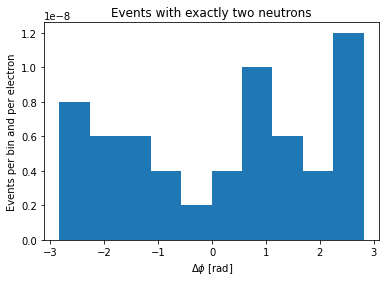

In [68]:
# Delta-phi(n,n)
plot_histo(df_nn_kinematics, 'delta_phi', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = r"$\Delta \phi$ [rad]", 
           y_label     = "Events per bin and per electron",
           file_name   = "delta_phi_nn",
           folder_name = output_folder)

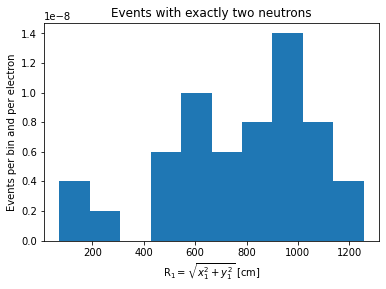

In [69]:
# r_1: distance of first neutron from the center of the detector
plot_histo(df_nn_kinematics, 'r_1', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "R$_1 = \sqrt{x_1^2 + y_1^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_1_nn",
           folder_name = output_folder)

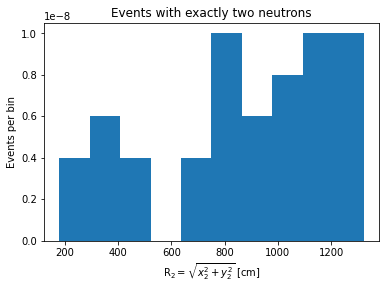

In [70]:
# r_2: distance of second neutron from the center of the detector
plot_histo(df_nn_kinematics, 'r_2', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "R$_2 = \sqrt{x_2^2 + y_2^2}$ [cm]", 
           y_label     = "Events per bin",
           file_name   = "r_2_nn",
           folder_name = output_folder)

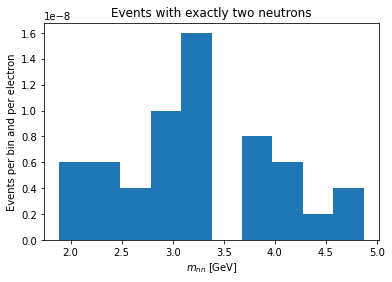

In [71]:
# m_nn: invariant mass of the two neutrons system
plot_histo(df_nn_kinematics, 'm_nn', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "$m_{nn}$ [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "m_nn",
           folder_name = output_folder)

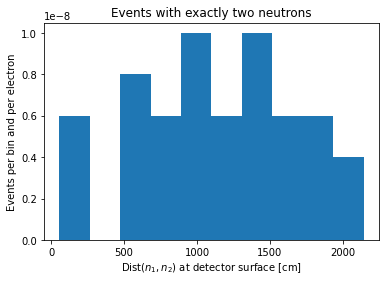

In [72]:
# dist_n1_n2: distance between the two neutrons at the detector surface
plot_histo(df_nn_kinematics, 'dist_n1_n2', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "Dist($n_1,n_2$) at detector surface [cm]",
           y_label     = "Events per bin and per electron",
           file_name   = "dist_n1_n2",
           folder_name = output_folder)

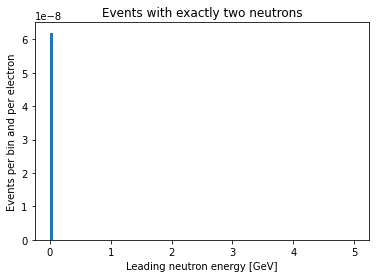

In [73]:
# E_1: leading neutron energy
plot_histo(df_nn_kinematics, 'E_1', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           title       = "Events with exactly two neutrons", 
           x_label     = "Leading neutron energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_n1",
           folder_name = output_folder)

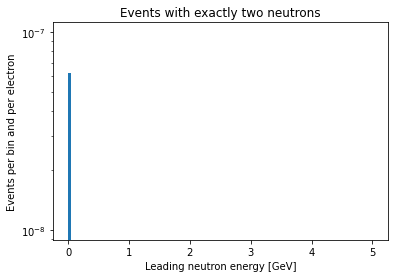

In [74]:
# E_1: leading neutron energy (log scale)
plot_histo(df_nn_kinematics, 'E_1', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           y_log       = True,
           title       = "Events with exactly two neutrons", 
           x_label     = "Leading neutron energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_n1_log",
           folder_name = output_folder)

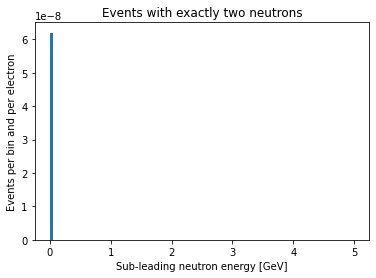

In [75]:
# E_2: sub-leading neutron energy
plot_histo(df_nn_kinematics, 'E_2', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           title       = "Events with exactly two neutrons", 
           x_label     = "Sub-leading neutron energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_n2",
           folder_name = output_folder)

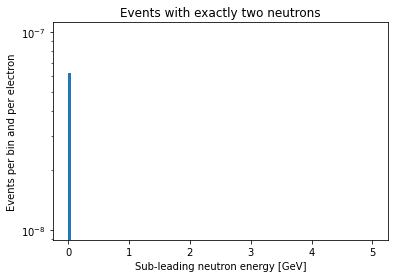

In [76]:
# E_2: sub-leading neutron energy (log scale)
plot_histo(df_nn_kinematics, 'E_2', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           y_log       = True,
           title       = "Events with exactly two neutrons", 
           x_label     = "Sub-leading neutron energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_n2_log",
           folder_name = output_folder)

### Two photons case
We move to events with two photons. We select photons using the `pdg` variable, that for photons is `22`.

In the code, we will use the 'y' letter instead of '$\gamma$'.

In [77]:
# Select events with exactly two photons
def get_sum(df_bsm):
    """Returns sum of 'pdg' values in each event"""
    return sum(df_bsm['pdg'])

def is_photon(df_bsm):
    """Returns number of photons in each event"""
    return sum(df_bsm['pdg'] == 22)


# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has EXACTLY two photons
list_yy = df_bsm.groupby('entry').apply(get_sum)==44

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST two photons
list_multi_y = df_bsm.groupby('entry').apply(is_photon) > 1

In [78]:
# We convert the series into a 'mask' that we use to filter the dataframe
mask_yy = list_multi_y[list_multi_y==True].index # At least two neutrons in the event

In [79]:
# Here we filter
df_bsm_yy = df_bsm.loc[mask_yy]
df_bsm_yy.head(15)

E   pdg  detid  weight     theta       phi  \
entry subentry                                                          
145   16        4.189718e-06  2112   9000    15.0  1.073171 -2.277851   
      18        1.312131e-03    22   9000    15.0  1.449273  1.106148   
      20        7.121476e-05    22   9000    15.0  1.043415  1.631965   
3213  50        1.152966e-04    22   9000    15.0  0.438794 -0.279449   
      52        9.835282e-04    22   9000    15.0  0.446999 -0.300076   
3904  14        1.654511e-04    22   9000    15.0  2.671127 -1.632834   
      15        5.269204e-03    22   9000    15.0  0.518138  0.107051   
5203  31        3.660796e-03    22   9000    15.0  2.187595 -2.123325   
      34        5.088456e-04    22   9000    15.0  2.372177 -0.186812   
      35        2.971576e-04    22   9000    15.0  2.401467  0.197346   
6571  38        4.634538e-04   -12   9000    15.0  0.048250  1.892356   
      82        8.090449e-05    22   9000    15.0  1.880545  1.938907   
      87        9.826317e-04    22   9000    15.0  0.727056  2.250304   
      122       7.216669e-08  2112   9000    15.0  0.669197 -0.119555   
6619  11        8.557281e-05    22   9000    15.0  1.031744 -0.702016   

                       vtxx         vtxy          vtxz        px        py  \
entry subentry                                                               
145   16         -71.405391   -65.903453   7130.353868 -0.001602 -0.001875   
      18        -677.570176 -1128.862202  15832.425023  0.000584  0.001164   
      20        -677.570176 -1128.862202  15832.425023 -0.000004  0.000061   
3213  50       -3837.725670  1314.544845   9801.036711  0.000047 -0.000014   
      52       -3837.725670  1314.544844   9801.036711  0.000406 -0.000126   
3904  14       -2697.323866   224.909014  13014.384743 -0.000005 -0.000075   
      15       -2697.323866   224.909014  13014.384743  0.002595  0.000279   
5203  31        -197.311898  1939.355227  16930.036927 -0.001567 -0.002542   
      34       -2685.346284   343.473806  18277.274893  0.000348 -0.000066   
      35       -2685.346284   343.473806  18277.274893  0.000197  0.000039   
6571  38        -357.401646  -324.221010   7504.288376 -0.000007  0.000021   
      82        -361.766977 -1411.916702  16319.467411 -0.000028  0.000072   
      87        1601.942737 -1863.482045  12506.237242 -0.000410  0.000508   
      122       -164.181569   193.748088   7469.217454  0.000227 -0.000027   
6619  11       -1962.183827  1982.209590  15194.865277  0.000056 -0.000047   

                      pz            x            y             z  
entry subentry                                                    
145   16        0.001339   265.295243  1002.500000  16120.867985  
      18        0.000159   -62.692465    97.823992  16000.000000  
      20        0.000036  -667.081331  -811.895314  16000.000000  
3213  50        0.000104 -1002.500000   510.330271  16074.162155  
      52        0.000887  -998.981753   436.182798  16000.000000  
3904  14       -0.000147  -873.934891   696.870457  16178.060000  
      15        0.004578 -1002.500000   407.038556  16004.398045  
5203  31       -0.002118  -774.966843  1002.500000  16149.595894  
      34       -0.000366  -680.764088   -61.142762  16178.060000  
      35       -0.000219  -757.340757   655.940536  16178.060000  
6571  38        0.000463  -487.055962    64.990038  16000.000000  
      82       -0.000025  -713.720636  -420.313900  16178.060000  
      87        0.000734  -190.770069   442.100482  16000.000000  
      122       0.000289   464.531381  -285.828359  16000.000000  
6619  11        0.000044  -862.407426  1002.500000  16098.466871

As we did in the two-neutron case, now that we selected events with at least two photons, we want to order, in each event, the particles by their energy, and keep events in which the two most energetic particles are photons.

In [80]:
# Sort by particle Energy
df_bsm_yy_sort = df_bsm_yy.groupby('entry').apply(lambda x: x.sort_values(['E'], ascending=False))
df_bsm_yy_sort.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
145   145   18        1.312131e-03    22   9000    15.0  1.449273  1.106148   
            20        7.121476e-05    22   9000    15.0  1.043415  1.631965   
            16        4.189718e-06  2112   9000    15.0  1.073171 -2.277851   
3213  3213  52        9.835282e-04    22   9000    15.0  0.446999 -0.300076   
            50        1.152966e-04    22   9000    15.0  0.438794 -0.279449   
3904  3904  15        5.269204e-03    22   9000    15.0  0.518138  0.107051   
            14        1.654511e-04    22   9000    15.0  2.671127 -1.632834   
5203  5203  31        3.660796e-03    22   9000    15.0  2.187595 -2.123325   
            34        5.088456e-04    22   9000    15.0  2.372177 -0.186812   
            35        2.971576e-04    22   9000    15.0  2.401467  0.197346   
6571  6571  87        9.826317e-04    22   9000    15.0  0.727056  2.250304   
            38        4.634538e-04   -12   9000    15.0  0.048250  1.892356   
            82        8.090449e-05    22   9000    15.0  1.880545  1.938907   
            122       7.216669e-08  2112   9000    15.0  0.669197 -0.119555   
6619  6619  20        1.587609e-04    22   9000    15.0  2.511900  1.940480   
            11        8.557281e-05    22   9000    15.0  1.031744 -0.702016   
            18        2.000819e-06  2112   9000    15.0  2.378535 -0.459993   
            32        3.749884e-09  2112   9000    15.0  1.996956 -2.524739   
7213  7213  11        1.510359e-03    22   9000    15.0  1.016544 -1.367311   
            14        1.605110e-04    22   9000    15.0  1.017642 -1.094090   

                             vtxx         vtxy          vtxz        px  \
entry entry subentry                                                     
145   145   18        -677.570176 -1128.862202  15832.425023  0.000584   
            20        -677.570176 -1128.862202  15832.425023 -0.000004   
            16         -71.405391   -65.903453   7130.353868 -0.001602   
3213  3213  52       -3837.725670  1314.544844   9801.036711  0.000406   
            50       -3837.725670  1314.544845   9801.036711  0.000047   
3904  3904  15       -2697.323866   224.909014  13014.384743  0.002595   
            14       -2697.323866   224.909014  13014.384743 -0.000005   
5203  5203  31        -197.311898  1939.355227  16930.036927 -0.001567   
            34       -2685.346284   343.473806  18277.274893  0.000348   
            35       -2685.346284   343.473806  18277.274893  0.000197   
6571  6571  87        1601.942737 -1863.482045  12506.237242 -0.000410   
            38        -357.401646  -324.221010   7504.288376 -0.000007   
            82        -361.766977 -1411.916702  16319.467411 -0.000028   
            122       -164.181569   193.748088   7469.217454  0.000227   
6619  6619  20         117.529233  -218.827846  16134.512169 -0.000034   
            11       -1962.183827  1982.209590  15194.865277  0.000056   
            18         114.582463   161.252280   7447.447345  0.001201   
            32        -112.682850   101.437032   7322.598156 -0.000062   
7213  7213  11         262.076060  1933.264772  15033.216933  0.000260   
            14         262.076060  1933.264772  15033.216933  0.000063   

                            py        pz            x            y  \
entry entry subentry                                                 
145   145   18        0.001164  0.000159   -62.692465    97.823992   
            20        0.000061  0.000036  -667.081331  -811.895314   
            16       -0.001875  0.001339   265.295243  1002.500000   
3213  3213  52       -0.000126  0.000887  -998.981753   436.182798   
            50       -0.000014  0.000104 -1002.500000   510.330271   
3904  3904  15        0.000279  0.004578 -1002.500000   407.038556   
            14       -0.000075 -0.000147  -873.934891   696.870457   
5203  5203  31       -0.002542 -0.0

In [81]:
# Leading particle is a photon
photon_mask_0 = df_bsm_yy_sort.groupby('entry').nth(0)['pdg'] == 22
print(photon_mask_0[:10])

# Sub-leading particle is a photon
photon_mask_1 = df_bsm_yy_sort.groupby('entry').nth(1)['pdg'] == 22
print(photon_mask_1[:10])

entry
145     True
3213    True
3904    True
5203    True
6571    True
6619    True
7213    True
8127    True
Name: pdg, dtype: bool
entry
145      True
3213     True
3904     True
5203     True
6571    False
6619     True
7213     True
8127     True
Name: pdg, dtype: bool


In [82]:
photon_mask = photon_mask_0 & photon_mask_1
print(photon_mask[0:10])

mask_two_y = photon_mask[photon_mask==True].index # Two leading particles are photons

entry
145      True
3213     True
3904     True
5203     True
6571    False
6619     True
7213     True
8127     True
Name: pdg, dtype: bool


In [83]:
# Apply mask to have only events in which two leading particles are photons
df_bsm_two_y = df_bsm_yy_sort.loc[mask_two_y]
df_bsm_two_y.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
145   145   18        1.312131e-03    22   9000    15.0  1.449273  1.106148   
            20        7.121476e-05    22   9000    15.0  1.043415  1.631965   
            16        4.189718e-06  2112   9000    15.0  1.073171 -2.277851   
3213  3213  52        9.835282e-04    22   9000    15.0  0.446999 -0.300076   
            50        1.152966e-04    22   9000    15.0  0.438794 -0.279449   
3904  3904  15        5.269204e-03    22   9000    15.0  0.518138  0.107051   
            14        1.654511e-04    22   9000    15.0  2.671127 -1.632834   
5203  5203  31        3.660796e-03    22   9000    15.0  2.187595 -2.123325   
            34        5.088456e-04    22   9000    15.0  2.372177 -0.186812   
            35        2.971576e-04    22   9000    15.0  2.401467  0.197346   
6619  6619  20        1.587609e-04    22   9000    15.0  2.511900  1.940480   
            11        8.557281e-05    22   9000    15.0  1.031744 -0.702016   
            18        2.000819e-06  2112   9000    15.0  2.378535 -0.459993   
            32        3.749884e-09  2112   9000    15.0  1.996956 -2.524739   
7213  7213  11        1.510359e-03    22   9000    15.0  1.016544 -1.367311   
            14        1.605110e-04    22   9000    15.0  1.017642 -1.094090   
            12        1.561337e-04    22   9000    15.0  0.109355 -0.944659   
8127  8127  14        1.517687e-04    22   9000    15.0  1.844288 -2.187898   
            22        9.653388e-05    22   9000    15.0  1.277880 -0.371352   

                             vtxx         vtxy          vtxz        px  \
entry entry subentry                                                     
145   145   18        -677.570176 -1128.862202  15832.425023  0.000584   
            20        -677.570176 -1128.862202  15832.425023 -0.000004   
            16         -71.405391   -65.903453   7130.353868 -0.001602   
3213  3213  52       -3837.725670  1314.544844   9801.036711  0.000406   
            50       -3837.725670  1314.544845   9801.036711  0.000047   
3904  3904  15       -2697.323866   224.909014  13014.384743  0.002595   
            14       -2697.323866   224.909014  13014.384743 -0.000005   
5203  5203  31        -197.311898  1939.355227  16930.036927 -0.001567   
            34       -2685.346284   343.473806  18277.274893  0.000348   
            35       -2685.346284   343.473806  18277.274893  0.000197   
6619  6619  20         117.529233  -218.827846  16134.512169 -0.000034   
            11       -1962.183827  1982.209590  15194.865277  0.000056   
            18         114.582463   161.252280   7447.447345  0.001201   
            32        -112.682850   101.437032   7322.598156 -0.000062   
7213  7213  11         262.076060  1933.264772  15033.216933  0.000260   
            14         262.076060  1933.264772  15033.216933  0.000063   
            12         262.076060  1933.264772  15033.216933  0.000010   
8127  8127  14        1217.579320   397.929773  12793.087021 -0.000085   
            22       -3318.229122   778.338731  14745.724332  0.000086   

                            py        pz            x            y  \
entry entry subentry                                                 
145   145   18        0.001164  0.000159   -62.692465    97.823992   
            20        0.000061  0.000036  -667.081331  -811.895314   
            16       -0.001875  0.001339   265.295243  1002.500000   
3213  3213  52       -0.000126  0.000887  -998.981753   436.182798   
            50       -0.000014  0.000104 -1002.500000   510.330271   
3904  3904  15        0.000279  0.004578 -1002.500000   407.038556   
            14       -0.000075 -0.000147  -873.934891   696.870457   
5203  5203  31       -0.002542 -0.002118  -774.966843  1002.500000   
            34       -0.000066 -0.000366  -680.764088   -61.142762   
            35        0.000039 -0.000219  -757.3

In [84]:
# Two leading particles in the event are photons
df_bsm_yy_sort.iloc[0:2]

E  pdg  detid  weight     theta       phi  \
entry entry subentry                                                     
145   145   18        0.001312   22   9000    15.0  1.449273  1.106148   
            20        0.000071   22   9000    15.0  1.043415  1.631965   

                            vtxx         vtxy          vtxz        px  \
entry entry subentry                                                    
145   145   18       -677.570176 -1128.862202  15832.425023  0.000584   
            20       -677.570176 -1128.862202  15832.425023 -0.000004   

                            py        pz           x           y        z  
entry entry subentry                                                       
145   145   18        0.001164  0.000159  -62.692465   97.823992  16000.0  
            20        0.000061  0.000036 -667.081331 -811.895314  16000.0



Now we build some interesting kinematic variables, per event.


In [85]:
df_yy_kinematics = pd.DataFrame()

In [86]:
# Delta phi 
def delta_phi(df_yy_kinematics):
    d_phi = df_yy_kinematics['phi_1'] - df_yy_kinematics['phi_2']    
    if d_phi >= np.pi: d_phi = d_phi - 2*np.pi
    if d_phi < -np.pi: d_phi = d_phi + 2*np.pi
    return d_phi


# Copying TLorentzVector definition https://root.cern.ch/doc/master/TLorentzVector_8h_source.html#l00498
def inv_mass(E_1, px_1, py_1, pz_1,
             E_2, px_2, py_2, pz_2):
    return np.sqrt( np.absolute((E_1+E_2)**2 - (px_1+px_2)**2 - (py_1+py_2)**2 - (pz_1+pz_2)**2) )

In [87]:
# Dirty trick to have the first and second particles: create two separate dataframes
# with the first and second subentry
df_bsm_yy_first  = df_bsm_two_y.groupby('entry').nth(0)
df_bsm_yy_second = df_bsm_two_y.groupby('entry').nth(1)

In [88]:
# Event variables
df_yy_kinematics["weight"] = df_bsm_yy_first["weight"]

# Build first particle
df_yy_kinematics["E_1"] = df_bsm_yy_first["E"]
df_yy_kinematics["m_1"] = 0.939565
df_yy_kinematics["eta_1"] = -np.log(np.tan(0.5*df_bsm_yy_first["theta"]))
df_yy_kinematics["theta_1"] = df_bsm_yy_first["theta"]
df_yy_kinematics["phi_1"] = df_bsm_yy_first["phi"]
df_yy_kinematics["vtxx_1"] = df_bsm_yy_first["vtxx"]
df_yy_kinematics["vtxy_1"] = df_bsm_yy_first["vtxy"]
df_yy_kinematics["vtxz_1"] = df_bsm_yy_first["vtxz"]
df_yy_kinematics["px_1"] = df_bsm_yy_first["px"]
df_yy_kinematics["py_1"] = df_bsm_yy_first["py"]
df_yy_kinematics["pz_1"] = df_bsm_yy_first["pz"]
df_yy_kinematics["x_1"] = df_bsm_yy_first["x"]
df_yy_kinematics["y_1"] = df_bsm_yy_first["y"]
df_yy_kinematics["z_1"] = df_bsm_yy_first["z"]

# Build second particle
df_yy_kinematics["E_2"] = df_bsm_yy_second["E"]
df_yy_kinematics["m_2"] = 0.939565
df_yy_kinematics["eta_2"] = -np.log(np.tan(0.5*df_bsm_yy_second["theta"]))
df_yy_kinematics["theta_2"] = df_bsm_yy_second["theta"]
df_yy_kinematics["phi_2"] = df_bsm_yy_second["phi"]
df_yy_kinematics["vtxx_2"] = df_bsm_yy_second["vtxx"]
df_yy_kinematics["vtxy_2"] = df_bsm_yy_second["vtxy"]
df_yy_kinematics["vtxz_2"] = df_bsm_yy_second["vtxz"]
df_yy_kinematics["px_2"] = df_bsm_yy_second["px"]
df_yy_kinematics["py_2"] = df_bsm_yy_second["py"]
df_yy_kinematics["pz_2"] = df_bsm_yy_second["pz"]
df_yy_kinematics["x_2"] = df_bsm_yy_second["x"]
df_yy_kinematics["y_2"] = df_bsm_yy_second["y"]
df_yy_kinematics["z_2"] = df_bsm_yy_second["z"]


In [89]:
df_yy_kinematics["m_yy"] = inv_mass(df_yy_kinematics["E_1"], df_yy_kinematics["m_1"], df_yy_kinematics["eta_1"], df_yy_kinematics["phi_1"],
                                    df_yy_kinematics["E_2"], df_yy_kinematics["m_2"], df_yy_kinematics["eta_2"], df_yy_kinematics["phi_2"])                                    

In [90]:
# particle distance from the center of the detector
df_yy_kinematics["r_1"] = np.sqrt(df_yy_kinematics["x_1"]**2 + df_yy_kinematics["y_1"]**2)
df_yy_kinematics["r_2"] = np.sqrt(df_yy_kinematics["x_2"]**2 + df_yy_kinematics["y_2"]**2)

# Distance between the two particles at the detector surface
df_yy_kinematics["dist_n1_n2"] = np.sqrt( (df_yy_kinematics["x_2"] - df_yy_kinematics["x_1"])**2 + (df_yy_kinematics["y_1"] - df_yy_kinematics["y_2"])**2)

In [91]:
# Delta_phi between photons
df_yy_kinematics["delta_phi"] = df_yy_kinematics.apply(delta_phi, axis = 1)
df_yy_kinematics[['E_1','E_2','phi_1','phi_2','delta_phi']].head(10)

,E_1,E_2,phi_1,phi_2,delta_phi
entry,,,,,
145,0.001312,0.000071,1.106148,1.631965,-0.525817
3213,0.000984,0.000115,-0.300076,-0.279449,-0.020627
3904,0.005269,0.000165,0.107051,-1.632834,1.739886
5203,0.003661,0.000509,-2.123325,-0.186812,-1.936513
6619,0.000159,0.000086,1.940480,-0.702016,2.642496
7213,0.001510,0.000161,-1.367311,-1.094090,-0.273221
8127,0.000152,0.000097,-2.187898,-0.371352,-1.816546


In [92]:
# Having a look at the dataframe
df_yy_kinematics.head(5)

,weight,E_1,m_1,eta_1,theta_1,phi_1,vtxx_1,vtxy_1,vtxz_1,px_1,...,py_2,pz_2,x_2,y_2,z_2,m_yy,r_1,r_2,dist_n1_n2,delta_phi
entry,,,,,,,,,,,,,,,,,,,,,
145,15.0,0.001312,0.939565,0.121823,1.449273,1.106148,-677.570176,-1128.862202,15832.425023,0.000584,...,0.000061,0.000036,-667.081331,-811.895314,16000.000000,3.388908,116.188977,1050.795652,1092.188224,-0.525817
3213,15.0,0.000984,0.939565,1.481499,0.446999,-0.300076,-3837.725670,1314.544844,9801.036711,0.000406,...,-0.000014,0.000104,-1002.500000,510.330271,16074.162155,3.572137,1090.055034,1124.919213,74.230895,-0.020627
3904,15.0,0.005269,0.939565,1.327932,0.518138,0.107051,-2697.323866,224.909014,13014.384743,0.002595,...,-0.000075,-0.000147,-873.934891,696.870457,16178.060000,2.422648,1081.982734,1117.761436,317.067056,1.739886
5203,15.0,0.003661,0.939565,-0.660095,2.187595,-2.123325,-197.311898,1939.355227,16930.036927,-0.001567,...,-0.000066,-0.000366,-680.764088,-61.142762,16178.060000,3.363738,1267.114777,683.504339,1067.806201,-1.936513
6619,15.0,0.000159,0.939565,-1.121842,2.511900,1.940480,117.529233,-218.827846,16134.512169,-0.000034,...,-0.000047,0.000044,-862.407426,1002.500000,16098.466871,2.317869,520.022716,1322.404181,1076.613157,2.642496


Now, finally plotting. We define again a function for that - the same we defined for neutrons - and we plot some distributions.

In [93]:
import matplotlib.pyplot as plt
import sys,os

def plot_histo(df, variable, weight=1, bins=10, range=None, title="", x_label="", y_label="", file_name=None, folder_name=None, file_format="png", y_log=False):
    """Plots distributions from a dataframe

    df: input dataframe
    variable: distribution to plot
    title: appears on top of the plot
    weight: weight to apply to the histogram
    bins: number of bins
    range: x-axis range (tuple)
    x_label: label of x-axis
    y_label: label of y-axis
    file_name: if not empty, name of file where plot is printed
    folder_name: if not empty, name of directory where plot is printed
    file_format: if file_name not empty, format of output file
    """

    # Prepare histogram
    # df[variable].plot(kind='hist', weights=weight)
    plt.hist(df[variable], bins=bins, weights=weight, range=range)
    if y_log == True:
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Preparing output
    if file_name:
        output_name = file_name + "." + file_format
        if folder_name:
            command = "mkdir -p {}".format(folder_name)
            os.system(command)
            output_name = folder_name + "/" + file_name + "." + file_format
        plt.savefig(output_name)

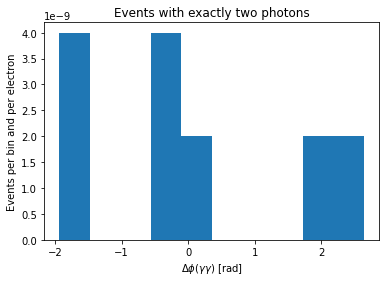

In [94]:
# Delta-phi(y,y)
plot_histo(df_yy_kinematics, 'delta_phi', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = r"$\Delta \phi (\gamma \gamma)$ [rad]", 
           y_label     = "Events per bin and per electron",
           file_name   = "delta_phi_yy",
           folder_name = output_folder)

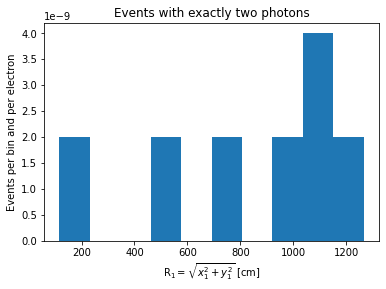

In [95]:
# r_1: distance of first photon from the center of the detector
plot_histo(df_yy_kinematics, 'r_1', 
           weight    = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title     = "Events with exactly two photons", 
           x_label   = "R$_1 = \sqrt{x_1^2 + y_1^2}$ [cm]", 
           y_label   = "Events per bin and per electron",
           file_name = "r_1_yy",
           folder_name = output_folder)

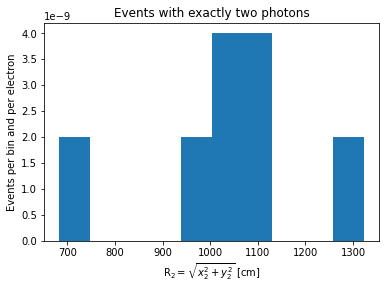

In [96]:
# r_2: distance of second photon from the center of the detector
plot_histo(df_yy_kinematics, 'r_2', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = "R$_2 = \sqrt{x_2^2 + y_2^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_2_yy",
           folder_name = output_folder)

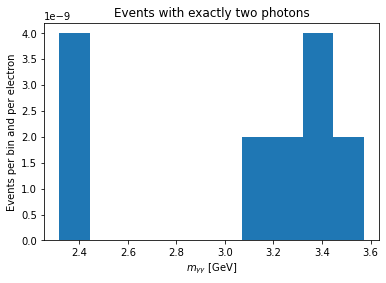

In [97]:
# m_yy: invariant mass of the two photons system
plot_histo(df_yy_kinematics, 'm_yy', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = "$m_{\gamma \gamma}$ [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "m_yy",
           folder_name = output_folder)

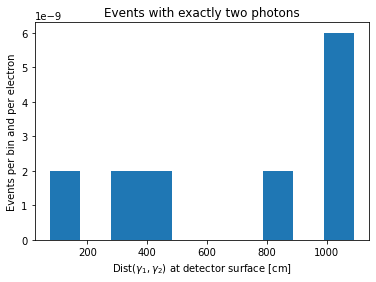

In [98]:
# dist_n1_n2: distance between the two photons at the detector surface
plot_histo(df_yy_kinematics, 'dist_n1_n2', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = "Dist($\gamma_1,\gamma_2$) at detector surface [cm]",
           y_label     = "Events per bin and per electron",
           file_name   = "dist_y1_y2",
           folder_name = output_folder)

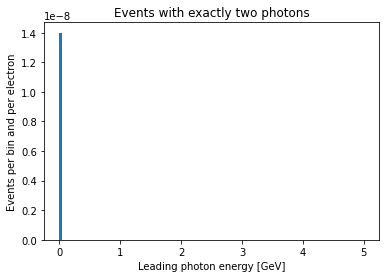

In [99]:
# E_1: leading photon energy
plot_histo(df_yy_kinematics, 'E_1', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           title       = "Events with exactly two photons", 
           x_label     = "Leading photon energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y1",
           folder_name = output_folder)

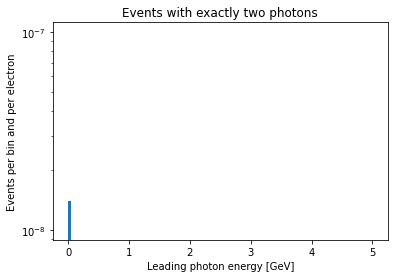

In [100]:
# E_1: leading photon energy (log scale)
plot_histo(df_yy_kinematics, 'E_1', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           y_log       = True,
           title       = "Events with exactly two photons", 
           x_label     = "Leading photon energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y1_log",
           folder_name = output_folder)

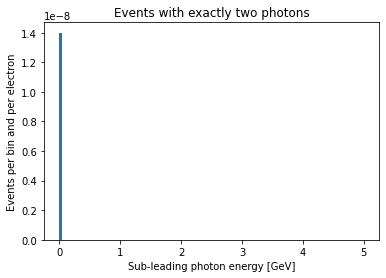

In [101]:
# E_2: sub-leading photon energy
plot_histo(df_yy_kinematics, 'E_2', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           title       = "Events with exactly two photons", 
           x_label     = "Sub-leading photon energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y2",
           folder_name = output_folder)

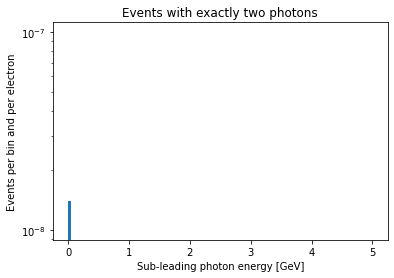

In [102]:
# E_2: sub-leading photon energy (log scale)
plot_histo(df_yy_kinematics, 'E_2', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           y_log       = True,
           title       = "Events with exactly two photons", 
           x_label     = "Sub-leading photon energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y2_log",
           folder_name = output_folder)

### Case one photon and one neutron

Finally, we look at events with one photon and one neutron. We will use functions and definitions introduced in the previous cases.

In [103]:
# Select events with photons or neutrons
def is_photon(df_bsm):
    """Returns number of photons in each event"""
    return sum(df_bsm['pdg'] == 22)

def is_neutron(df_bsm):
    """Returns number of neutrons in each event"""
    return sum(df_bsm['pdg'] == 2112)

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST one photon
list_one_y = df_bsm.groupby('entry').apply(is_photon) > 0

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST one neutron
list_one_n = df_bsm.groupby('entry').apply(is_neutron) > 0

In [104]:
print(list_one_y[0:10])
print(list_one_n[0:10])

entry
28     False
29     False
84     False
97     False
112    False
123    False
145     True
188    False
200    False
221    False
dtype: bool
entry
28      True
29      True
84      True
97      True
112     True
123    False
145     True
188    False
200     True
221     True
dtype: bool


In [105]:
# Now create an AND of the two pandas series and convert them into a single 'mask' that we use to filter the dataframe
list_yn = list_one_y & list_one_n
print(list_yn[0:10])

mask_yn = list_yn[list_yn==True].index # At least one neutron and one photon in the event

entry
28     False
29     False
84     False
97     False
112    False
123    False
145     True
188    False
200    False
221    False
dtype: bool


In [106]:
# Here we filter
df_bsm_yn = df_bsm.loc[mask_yn]
df_bsm_yn.head(15)

E   pdg  detid  weight     theta       phi  \
entry subentry                                                          
145   16        4.189718e-06  2112   9000    15.0  1.073171 -2.277851   
      18        1.312131e-03    22   9000    15.0  1.449273  1.106148   
      20        7.121476e-05    22   9000    15.0  1.043415  1.631965   
502   11        2.332115e-08  2112   9000    15.0  1.650079 -1.891524   
      12        3.168402e-04    22   9000    15.0  2.177863  1.543060   
1508  10        2.399641e-08  2112   9000    15.0  1.878624  2.110690   
      12        1.037549e-03    22   9000    15.0  2.069875 -1.187600   
1570  16        7.645543e-03    22   9000    15.0  0.994989 -0.979889   
      21        1.485499e-05   -12   9000    15.0  0.125571 -0.317086   
      27        3.481564e-06  2112   9000    15.0  2.444602 -1.046124   
3114  15        9.494316e-04   -12   9000    15.0  1.845309 -1.536022   
      16        2.616027e-04    22   9000    15.0  2.069301 -1.325906   
      30        1.786322e-06  2112   9000    15.0  0.267064  0.189135   
3131  15        9.304048e-05  2112   9000    15.0  2.503912 -2.091900   
      16        5.826186e-06  2112   9000    15.0  1.323143  0.008252   

                       vtxx         vtxy          vtxz        px  \
entry subentry                                                     
145   16         -71.405391   -65.903453   7130.353868 -0.001602   
      18        -677.570176 -1128.862202  15832.425023  0.000584   
      20        -677.570176 -1128.862202  15832.425023 -0.000004   
502   11        -822.018233   471.041652   8199.872024 -0.000066   
      12        -859.896581 -2562.794845  17510.286833  0.000007   
1508  10         -77.443175    75.583283   7202.688352 -0.000104   
      12        -706.985757  1868.550645  17828.493599  0.000341   
1570  16       -2107.506689  1935.595144  14432.054449  0.003573   
      21         -96.453137  -319.236473   7822.156240  0.000002   
      27         356.380161   -94.485375   7485.182031  0.000822   
3114  15        -670.441321  2194.694989  17021.190930  0.000032   
      16        -670.441321  2194.694989  17021.190930  0.000056   
      30        -244.531766    37.756658   7286.284820  0.000475   
3131  15        -395.853809   214.936943   7201.356944 -0.003919   
      16        -395.853809   214.936943   7201.356944  0.003208   

                          py        pz           x            y             z  
entry subentry                                                                 
145   16       -1.874535e-03  0.001339  265.295243  1002.500000  16120.867985  
      18        1.164367e-03  0.000159  -62.692465    97.823992  16000.000000  
      20        6.142359e-05  0.000036 -667.081331  -811.895314  16000.000000  
502   11       -1.980415e-04 -0.000017   54.859839  1002.500000  16070.378244  
      12        2.601288e-04 -0.000181 -863.480458  -628.245059  16178.060000  
1508  10        1.735839e-04 -0.000064    1.302657   373.724891  16178.060000  
      12       -8.449228e-04 -0.000497  425.042406  -939.588263  16178.060000  
1570  16       -5.325353e-03  0.004163 -761.951086   -70.092349  16000.000000  
      21       -5.800897e-07  0.000015  884.416886  -641.116979  16000.000000  
      27       -1.421031e-03 -0.001961 -784.172159  1002.500000  16023.629330  
3114  15       -9.133298e-04 -0.000257 -566.354153  -797.325118  16178.060000  
      16       -2.229099e-04 -0.000125 -437.631539   926.407803  16178.060000  
      30        9.090309e-05  0.001767   62.563918  -779.859308  16000.000000  
3131  15       -6.827155e-03 -0.010624 -698.908877  -783.601623  16178.060000  
      16        2.647190e-05  0.000811  432.946902  -779.649307  16000.000000

As we did in the previous cases, we order, in each event, the particles by their energy, and keep events in which the two most energetic particles are one neutron and one photon.

In [107]:
# Sort by particle Energy
df_bsm_yn_sort = df_bsm_yn.groupby('entry').apply(lambda x: x.sort_values(['E'], ascending=False))
df_bsm_yn_sort.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
145   145   18        1.312131e-03    22   9000    15.0  1.449273  1.106148   
            20        7.121476e-05    22   9000    15.0  1.043415  1.631965   
            16        4.189718e-06  2112   9000    15.0  1.073171 -2.277851   
502   502   12        3.168402e-04    22   9000    15.0  2.177863  1.543060   
            11        2.332115e-08  2112   9000    15.0  1.650079 -1.891524   
1508  1508  12        1.037549e-03    22   9000    15.0  2.069875 -1.187600   
            10        2.399641e-08  2112   9000    15.0  1.878624  2.110690   
1570  1570  16        7.645543e-03    22   9000    15.0  0.994989 -0.979889   
            21        1.485499e-05   -12   9000    15.0  0.125571 -0.317086   
            27        3.481564e-06  2112   9000    15.0  2.444602 -1.046124   
3114  3114  15        9.494316e-04   -12   9000    15.0  1.845309 -1.536022   
            16        2.616027e-04    22   9000    15.0  2.069301 -1.325906   
            30        1.786322e-06  2112   9000    15.0  0.267064  0.189135   
3131  3131  17        1.112391e-04    22   9000    15.0  2.082013  0.643021   
            15        9.304048e-05  2112   9000    15.0  2.503912 -2.091900   
            16        5.826186e-06  2112   9000    15.0  1.323143  0.008252   
3921  3921  217       1.839578e-03    12   9000    15.0  0.071514  1.329549   
            127       1.521101e-04    22   9000    15.0  0.401145 -0.404772   
            186       4.123756e-05  2112   9000    15.0  2.180434 -2.299893   
            187       2.950551e-05  2112   9000    15.0  1.351635  2.207445   

                             vtxx         vtxy          vtxz        px  \
entry entry subentry                                                     
145   145   18        -677.570176 -1128.862202  15832.425023  0.000584   
            20        -677.570176 -1128.862202  15832.425023 -0.000004   
            16         -71.405391   -65.903453   7130.353868 -0.001602   
502   502   12        -859.896581 -2562.794845  17510.286833  0.000007   
            11        -822.018233   471.041652   8199.872024 -0.000066   
1508  1508  12        -706.985757  1868.550645  17828.493599  0.000341   
            10         -77.443175    75.583283   7202.688352 -0.000104   
1570  1570  16       -2107.506689  1935.595144  14432.054449  0.003573   
            21         -96.453137  -319.236473   7822.156240  0.000002   
            27         356.380161   -94.485375   7485.182031  0.000822   
3114  3114  15        -670.441321  2194.694989  17021.190930  0.000032   
            16        -670.441321  2194.694989  17021.190930  0.000056   
            30        -244.531766    37.756658   7286.284820  0.000475   
3131  3131  17       -2823.335431 -2515.378558  18108.424026  0.000078   
            15        -395.853809   214.936943   7201.356944 -0.003919   
            16        -395.853809   214.936943   7201.356944  0.003208   
3921  3921  217       -344.200062    56.966424   7176.198918  0.000031   
            127      -1147.812378    85.746068   8288.703218  0.000055   
            186       -371.848793    22.951736   8104.526419 -0.004808   
            187       -371.848793    22.951736   8104.526419 -0.004321   

                                py        pz           x            y  \
entry entry subentry                                                    
145   145   18        1.164367e-03  0.000159  -62.692465    97.823992   
            20        6.142359e-05  0.000036 -667.081331  -811.895314   
            16       -1.874535e-03  0.001339  265.295243  1002.500000   
502   502   12        2.601288e-04 -0.000181 -863.480458  -628.245059   
            11       -1.980415e-04 -0.000017   54.859839  1002.500000   
1508  1508  12       -8.449228e-04 -0.000497  425.042406  -939.588263   
            10        1.735839e-04 -0.000064    1.302657   373.724891   
1570  15

In [108]:
# First case: most energetic particle is a photon and second most energetic particle is a neutron
yn_mask = (df_bsm_yn_sort.groupby('entry').nth(0)['pdg'] == 22) & (df_bsm_yn_sort.groupby('entry').nth(1)['pdg'] == 2112) 
print(yn_mask[:10])

# Second case: most energetic particle is a neutron and second most energetic particle is a photon
ny_mask = (df_bsm_yn_sort.groupby('entry').nth(0)['pdg'] == 2112) & (df_bsm_yn_sort.groupby('entry').nth(1)['pdg'] == 22)
print(ny_mask[:10])

entry
145     False
502      True
1508     True
1570    False
3114    False
3131     True
3921    False
4772     True
6571    False
6619    False
Name: pdg, dtype: bool
entry
145     False
502     False
1508    False
1570    False
3114    False
3131    False
3921    False
4772    False
6571    False
6619    False
Name: pdg, dtype: bool


In [109]:
# Final mask: OR of the two previous cases
yn_or_ny_mask = yn_mask | ny_mask
print(yn_or_ny_mask[:10])

entry
145     False
502      True
1508     True
1570    False
3114    False
3131     True
3921    False
4772     True
6571    False
6619    False
Name: pdg, dtype: bool


In [110]:
# Create the actual mask - maybe not the clearest names :(
mask_yn_or_ny = yn_or_ny_mask[yn_or_ny_mask==True].index

In [111]:
# Apply the mask
df_bsm_yn_or_ny = df_bsm_yn_sort.loc[mask_yn_or_ny]
df_bsm_yn_or_ny.head(10)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
502   502   12        3.168402e-04    22   9000    15.0  2.177863  1.543060   
            11        2.332115e-08  2112   9000    15.0  1.650079 -1.891524   
1508  1508  12        1.037549e-03    22   9000    15.0  2.069875 -1.187600   
            10        2.399641e-08  2112   9000    15.0  1.878624  2.110690   
3131  3131  17        1.112391e-04    22   9000    15.0  2.082013  0.643021   
            15        9.304048e-05  2112   9000    15.0  2.503912 -2.091900   
            16        5.826186e-06  2112   9000    15.0  1.323143  0.008252   
4772  4772  21        1.120272e-04    22   9000    15.0  2.610519 -3.046253   
            20        4.798720e-07  2112   9000    15.0  1.115867 -1.729939   
8307  8307  15        9.846776e-05    22   9000    15.0  0.542452  1.319212   

                             vtxx         vtxy          vtxz        px  \
entry entry subentry                                                     
502   502   12        -859.896581 -2562.794845  17510.286833  0.000007   
            11        -822.018233   471.041652   8199.872024 -0.000066   
1508  1508  12        -706.985757  1868.550645  17828.493599  0.000341   
            10         -77.443175    75.583283   7202.688352 -0.000104   
3131  3131  17       -2823.335431 -2515.378558  18108.424026  0.000078   
            15        -395.853809   214.936943   7201.356944 -0.003919   
            16        -395.853809   214.936943   7201.356944  0.003208   
4772  4772  21        -345.122655   933.316757  16158.489772 -0.000056   
            20        -449.301024   -44.697329   7169.108325 -0.000135   
8307  8307  15         905.640601  -819.671475  12682.141720  0.000013   

                            py        pz           x            y  \
entry entry subentry                                                
502   502   12        0.000260 -0.000181 -863.480458  -628.245059   
            11       -0.000198 -0.000017   54.859839  1002.500000   
1508  1508  12       -0.000845 -0.000497  425.042406  -939.588263   
            10        0.000174 -0.000064    1.302657   373.724891   
3131  3131  17        0.000058 -0.000054 -208.046696  -398.791330   
            15       -0.006827 -0.010624 -698.908877  -783.601623   
            16        0.000026  0.000811  432.946902  -779.649307   
4772  4772  21       -0.000005 -0.000097  -81.189225   804.367172   
            20       -0.000842  0.000417 -412.672152  1002.500000   
8307  8307  15        0.000049  0.000084  760.215640  -852.438738   

                                 z  
entry entry subentry                
502   502   12        16178.060000  
            11        16070.378244  
1508  1508  12        16178.060000  
            10        16178.060000  
3131  3131  17        16178.060000  
            15        16178.060000  
            16        16000.000000  
4772  4772  21        16178.060000  
            20        16009.438327  
8307  8307  15        16000.000000

Now we build some interesting kinematic variables, per event.

In [112]:
df_yn_or_ny_kinematics = pd.DataFrame()

In [113]:
# Delta phi 
def delta_phi(df_yn_or_ny_kinematics):
    d_phi = df_yn_or_ny_kinematics['phi_1'] - df_yn_or_ny_kinematics['phi_2']    
    if d_phi >= np.pi: d_phi = d_phi - 2*np.pi
    if d_phi < -np.pi: d_phi = d_phi + 2*np.pi
    return d_phi
    

# Copying TLorentzVector definition https://root.cern.ch/doc/master/TLorentzVector_8h_source.html#l00498
def inv_mass(E_1, px_1, py_1, pz_1,
             E_2, px_2, py_2, pz_2):
    return np.sqrt( np.absolute((E_1+E_2)**2 - (px_1+px_2)**2 - (py_1+py_2)**2 - (pz_1+pz_2)**2) )

In [114]:
# Dirty trick to have the first and second particles: create two separate dataframes
# with the first and second subentry
df_bsm_yn_or_ny_first  = df_bsm_yn_or_ny.groupby('entry').nth(0)
df_bsm_yn_or_ny_second = df_bsm_yn_or_ny.groupby('entry').nth(1)

In [115]:
# Event variables
df_yn_or_ny_kinematics["weight"] = df_bsm_yn_or_ny_first["weight"]

# Build first particle
df_yn_or_ny_kinematics["E_1"] = df_bsm_yn_or_ny_first["E"]
df_yn_or_ny_kinematics["m_1"] = 0.939565
df_yn_or_ny_kinematics["eta_1"] = -np.log(np.tan(0.5*df_bsm_yn_or_ny_first["theta"]))
df_yn_or_ny_kinematics["theta_1"] = df_bsm_yn_or_ny_first["theta"]
df_yn_or_ny_kinematics["phi_1"] = df_bsm_yn_or_ny_first["phi"]
df_yn_or_ny_kinematics["vtxx_1"] = df_bsm_yn_or_ny_first["vtxx"]
df_yn_or_ny_kinematics["vtxy_1"] = df_bsm_yn_or_ny_first["vtxy"]
df_yn_or_ny_kinematics["vtxz_1"] = df_bsm_yn_or_ny_first["vtxz"]
df_yn_or_ny_kinematics["px_1"] = df_bsm_yn_or_ny_first["px"]
df_yn_or_ny_kinematics["py_1"] = df_bsm_yn_or_ny_first["py"]
df_yn_or_ny_kinematics["pz_1"] = df_bsm_yn_or_ny_first["pz"]
df_yn_or_ny_kinematics["x_1"] = df_bsm_yn_or_ny_first["x"]
df_yn_or_ny_kinematics["y_1"] = df_bsm_yn_or_ny_first["y"]
df_yn_or_ny_kinematics["z_1"] = df_bsm_yn_or_ny_first["z"]

# Build second particle
df_yn_or_ny_kinematics["E_2"] = df_bsm_yn_or_ny_second["E"]
df_yn_or_ny_kinematics["m_2"] = 0.939565
df_yn_or_ny_kinematics["eta_2"] = -np.log(np.tan(0.5*df_bsm_yn_or_ny_second["theta"]))
df_yn_or_ny_kinematics["theta_2"] = df_bsm_yn_or_ny_second["theta"]
df_yn_or_ny_kinematics["phi_2"] = df_bsm_yn_or_ny_second["phi"]
df_yn_or_ny_kinematics["vtxx_2"] = df_bsm_yn_or_ny_second["vtxx"]
df_yn_or_ny_kinematics["vtxy_2"] = df_bsm_yn_or_ny_second["vtxy"]
df_yn_or_ny_kinematics["vtxz_2"] = df_bsm_yn_or_ny_second["vtxz"]
df_yn_or_ny_kinematics["px_2"] = df_bsm_yn_or_ny_second["px"]
df_yn_or_ny_kinematics["py_2"] = df_bsm_yn_or_ny_second["py"]
df_yn_or_ny_kinematics["pz_2"] = df_bsm_yn_or_ny_second["pz"]
df_yn_or_ny_kinematics["x_2"] = df_bsm_yn_or_ny_second["x"]
df_yn_or_ny_kinematics["y_2"] = df_bsm_yn_or_ny_second["y"]
df_yn_or_ny_kinematics["z_2"] = df_bsm_yn_or_ny_second["z"]

In [116]:
df_yn_or_ny_kinematics["m_yn"] = inv_mass(df_yn_or_ny_kinematics["E_1"], df_yn_or_ny_kinematics["m_1"], df_yn_or_ny_kinematics["eta_1"], df_yn_or_ny_kinematics["phi_1"],
                                          df_yn_or_ny_kinematics["E_2"], df_yn_or_ny_kinematics["m_2"], df_yn_or_ny_kinematics["eta_2"], df_yn_or_ny_kinematics["phi_2"])

In [117]:
# particle distance from the center of the detector
df_yn_or_ny_kinematics["r_1"] = np.sqrt(df_yn_or_ny_kinematics["x_1"]**2 + df_yn_or_ny_kinematics["y_1"]**2)
df_yn_or_ny_kinematics["r_2"] = np.sqrt(df_yn_or_ny_kinematics["x_2"]**2 + df_yn_or_ny_kinematics["y_2"]**2)

# Distance between the two particles at the detector surface
df_yn_or_ny_kinematics["dist_yn"] = np.sqrt( (df_yn_or_ny_kinematics["x_2"] - df_yn_or_ny_kinematics["x_1"])**2 + (df_yn_or_ny_kinematics["y_1"] - df_yn_or_ny_kinematics["y_2"])**2)

In [118]:
# Delta_phi between photons
df_yn_or_ny_kinematics["delta_phi"] = df_yn_or_ny_kinematics.apply(delta_phi, axis = 1)
df_yn_or_ny_kinematics[['E_1','E_2','phi_1','phi_2','delta_phi']].head(10)

,E_1,E_2,phi_1,phi_2,delta_phi
entry,,,,,
502,0.000317,2.332115e-08,1.543060,-1.891524,-2.848602
1508,0.001038,2.399641e-08,-1.187600,2.110690,2.984896
3131,0.000111,9.304048e-05,0.643021,-2.091900,2.734921
4772,0.000112,4.798720e-07,-3.046253,-1.729939,-1.316314
8307,0.000098,6.068052e-06,1.319212,-1.731333,3.050545
8425,0.000168,3.700207e-07,-1.765303,1.889000,2.628883
8760,0.000180,1.032538e-04,-0.815593,0.537428,-1.353020
9849,0.000108,5.878930e-05,2.389426,-2.801466,-1.092293


In [119]:
# Having a look at the dataframe
df_yn_or_ny_kinematics.head(5)

,weight,E_1,m_1,eta_1,theta_1,phi_1,vtxx_1,vtxy_1,vtxz_1,px_1,...,py_2,pz_2,x_2,y_2,z_2,m_yn,r_1,r_2,dist_yn,delta_phi
entry,,,,,,,,,,,,,,,,,,,,,
502,15.0,0.000317,0.939565,-0.648205,2.177863,1.543060,-859.896581,-2562.794845,17510.286833,0.000007,...,-0.000198,-0.000017,54.859839,1002.500000,16070.378244,2.044973,1067.843788,1003.999926,1871.544375,-2.848602
1508,15.0,0.001038,0.939565,-0.521188,2.069875,-1.187600,-706.985757,1868.550645,17828.493599,0.000341,...,0.000174,-0.000064,1.302657,373.724891,16178.060000,2.253613,1031.255134,373.727161,1379.980729,2.984896
3131,15.0,0.000111,0.939565,-0.535059,2.082013,0.643021,-2823.335431,-2515.378558,18108.424026,0.000078,...,-0.006827,-0.010624,-698.908877,-783.601623,16178.060000,2.886378,449.797680,1050.002439,623.718400,2.734921
4772,15.0,0.000112,0.939565,-1.302104,2.610519,-3.046253,-345.122655,933.316757,16158.489772,-0.000056,...,-0.000842,0.000417,-412.672152,1002.500000,16009.438327,5.199333,808.454227,1084.114641,386.183309,-1.316314
8307,15.0,0.000098,0.939565,1.279852,0.542452,1.319212,905.640601,-819.671475,12682.141720,0.000013,...,-0.001435,0.003048,839.020479,-621.239272,16000.000000,3.368863,1142.181956,1043.979692,244.260918,3.050545


Now, finally plotting. We define again a function for that - the same we defined for neutrons - and we plot some distributions.

In [120]:
import matplotlib.pyplot as plt
import sys,os

def plot_histo(df, variable, weight=1, bins=10, range=None, title="", x_label="", y_label="", file_name=None, folder_name=None, file_format="png", y_log=False):
    """Plots distributions from a dataframe

    df: input dataframe
    variable: distribution to plot
    title: appears on top of the plot
    weight: weight to apply to the histogram
    bins: number of bins
    range: x-axis range (tuple)
    x_label: label of x-axis
    y_label: label of y-axis
    file_name: if not empty, name of file where plot is printed
    folder_name: if not empty, name of directory where plot is printed
    file_format: if file_name not empty, format of output file
    """

    # Prepare histogram
    # df[variable].plot(kind='hist', weights=weight)
    plt.hist(df[variable], bins=bins, weights=weight, range=range)
    if y_log == True:
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Preparing output
    if file_name:
        output_name = file_name + "." + file_format
        if folder_name:
            command = "mkdir -p {}".format(folder_name)
            os.system(command)
            output_name = folder_name + "/" + file_name + "." + file_format
        plt.savefig(output_name)

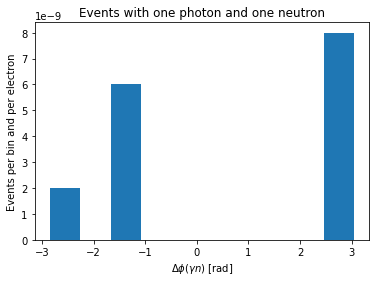

In [121]:
# Delta-phi(y,n)
plot_histo(df_yn_or_ny_kinematics, 'delta_phi', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = r"$\Delta \phi (\gamma n)$ [rad]", 
           y_label     = "Events per bin and per electron",
           file_name   = "delta_phi_yn",
           folder_name = output_folder)

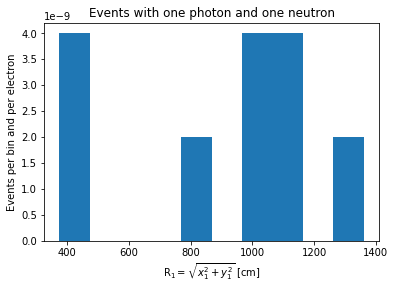

In [122]:
# r_1: distance of first particle from the center of the detector
plot_histo(df_yn_or_ny_kinematics, 'r_1', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "R$_1 = \sqrt{x_1^2 + y_1^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_1_yn",
           folder_name = output_folder)

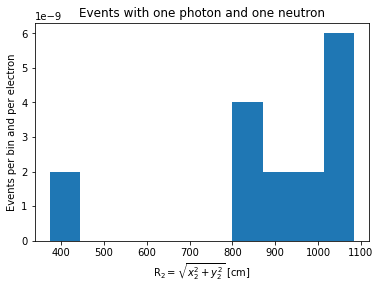

In [123]:
# r_2: distance of second particle from the center of the detector
plot_histo(df_yn_or_ny_kinematics, 'r_2', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "R$_2 = \sqrt{x_2^2 + y_2^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_2_yn",
           folder_name = output_folder)

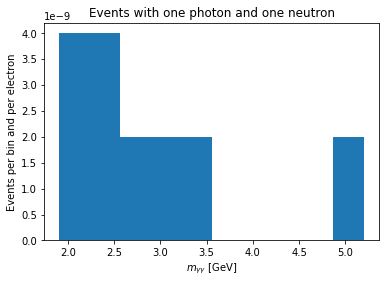

In [124]:
# m_yn: invariant mass of the two particles system
plot_histo(df_yn_or_ny_kinematics, 'm_yn', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "$m_{\gamma \gamma}$ [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "m_yn",
           folder_name = output_folder)

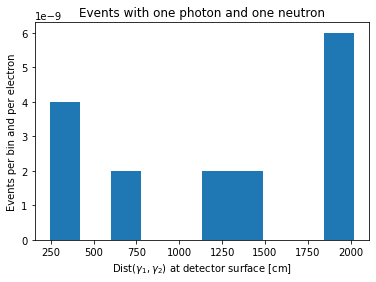

In [125]:
# dist_yn: distance between the two particles at the detector surface
plot_histo(df_yn_or_ny_kinematics, 'dist_yn', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "Dist($\gamma_1,\gamma_2$) at detector surface [cm]",
           y_label     = "Events per bin and per electron",
           file_name   = "dist_yn",
           folder_name = output_folder)

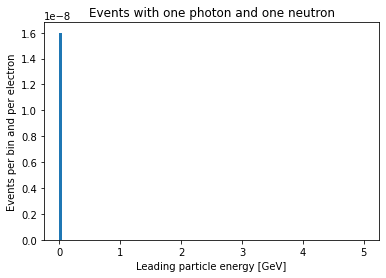

In [126]:
# E_1: leading particle energy
plot_histo(df_yn_or_ny_kinematics, 'E_1', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           title       = "Events with one photon and one neutron", 
           x_label     = "Leading particle energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y_or_n1",
           folder_name = output_folder)

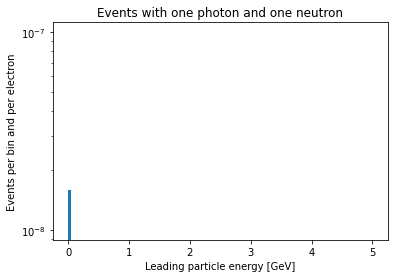

In [127]:
# E_1: leading particle energy (log scale)
plot_histo(df_yn_or_ny_kinematics, 'E_1', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           y_log       = True,
           title       = "Events with one photon and one neutron", 
           x_label     = "Leading particle energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y_or_n1_log",
           folder_name = output_folder)

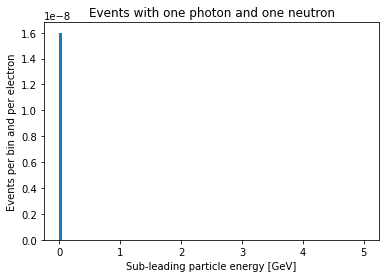

In [128]:
# E_2: sub-leading particle energy
plot_histo(df_yn_or_ny_kinematics, 'E_2', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           title       = "Events with one photon and one neutron", 
           x_label     = "Sub-leading particle energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y_or_n2",
           folder_name = output_folder)

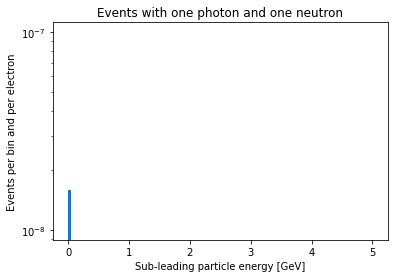

In [129]:
# E_2: sub-leading particle energy (log scale)
plot_histo(df_yn_or_ny_kinematics, 'E_2', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 100,
           range       = (0,5),
           y_log       = True,
           title       = "Events with one photon and one neutron", 
           x_label     = "Sub-leading particle energy [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "E_y_or_n2_log",
           folder_name = output_folder)

# Additional stuff or tests

In [86]:
df_nn_kinematics['delta_phi'].plot(kind="hist", weights=df['weight']/(1.5e9))
plt.title("Events with exactly two neutrons")
plt.xlabel(r"$\Delta \phi$ [rad]")
plt.ylabel("Events per bin")

NameError: name 'df' is not defined

<AxesSubplot:ylabel='Frequency'>

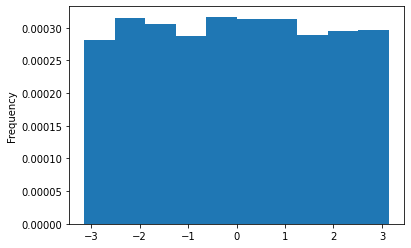

In [ ]:
df_nn_kinematics['delta_phi'].plot(kind="hist", weights=df_nn_kinematics['weight']/(1.5e9))

In [ ]:
# reference example
def get_sum_E(df_bsm_nn):
    return sum(df_bsm_nn['E'])

df_nn_kinematics = pd.DataFrame()

df_nn_kinematics['sum_E'] = df_bsm_nn.groupby('entry').apply(get_sum_E)


In [ ]:
df_nn_kinematics.head(10)